The aim of the notebook is run inference on the test dataset using the faster-rcnn model trained for 12 epochs. This is just to show the demo of how to use the mmdet framework for test inference. The accuracy obtained from the submission file created is only 0.027. The mmdet framework can be used to easily train and test multiple models with different backbones, so it will be easier to create ensemble of models for final evaluation.


# Training Notebook Link FasterRCNN

https://www.kaggle.com/gauravsingh1/mmdet-pytorch-framework-training-fasterrcnn-base

# Installing MMDET Framework

In [1]:
import os
import cv2
import random


In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
%%time

print("this will take around 10 mins")
# install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.7.0+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

this will take around 10 mins
     |████████████████████████████████| 231 kB 1.3 MB/s 
     |████████████████████████████████| 190 kB 5.4 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.7-cp37-cp37m-linux_x86_64.whl size=20707145 sha256=8486e198e9dbdacef871c8c78f74f47852213f7ffa136a4f0263774b0c66368f
  Stored in directory: /root/.cache/pip/wheels/3f/3d/5e/dbc82b2ea5f1e14d4fe044aea9aeb02a8a9402c051529659c2
Successfully built mmcv-full
CPU times: user 7.95 s, sys: 1.29 s, total: 9.24 s
Wall time: 8min 33s


In [4]:
!rm -rf mmdetection
!git clone --branch v2.7.0 https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Cloning into 'mmdetection'...
remote: Enumerating objects: 16271, done.
remote: Total 16271 (delta 0), reused 0 (delta 0), pack-reused 16271
Receiving objects: 100% (16271/16271), 19.01 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (11257/11257), done.
Note: checking out '3e902c3afc62693a71d672edab9b22e35f7d4776'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/kaggle/working/mmdetection
Obtaining file:///kaggle/working/mmdetection
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272910 sha256=499ad192945f5e29d730356b66f4c4d7ad6745b59994366a921ed8694d9a37dc
  Stored in directory: /root

# Test Installation

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.7.0 True
2.7.0
10.2
GCC 7.5


# Downloading Sample Checkpoints

In [6]:
!mkdir checkpoints
!wget -c http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-03-04 07:55:12--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  9.31MB/s    in 18s     

2021-03-04 07:55:32 (9.22 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



# Preparing test anno file: Coco Format

In [7]:
test_anno = "../../input/vinbigdata-1024-image-dataset/vinbigdata/test"

ids = os.listdir(test_anno)

In [8]:
img_infos = []
for i, _id in enumerate(ids):
    if '.png' in _id:
        img_infos.append({
                    "license": 0,
                    "url": 'null',
                    "file_name": _id,
                    "height": 1024,
                    "width": 1024,
                    "date_captured": 'null',
                    "id": _id
                })

In [9]:
img_infos[0]

{'license': 0,
 'url': 'null',
 'file_name': 'b3f67ac077531f44dd06275af31edbd9.png',
 'height': 1024,
 'width': 1024,
 'date_captured': 'null',
 'id': 'b3f67ac077531f44dd06275af31edbd9.png'}

Over here I am just replacing the contents of validation annotation file with the list of test images. The annotation key in the dictionary will be an empty list. Rest will be same for the test ann file.

In [10]:
import json
val_anno = '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_annotations.json'

with open(val_anno) as f:
    dd = json.load(f)

dd.keys()
dd['annotations']=[]
dd['images']
dd['images'] = img_infos
with open('./test_ann.json', 'w') as outfile:
    json.dump(dd, outfile)

In [11]:
val_ids = os.listdir('../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_images')

In [12]:
_classes = ("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")

MMDET framework gives the option to pass the extra config options as a command line arguments or one can pass the extra config in an dict variable in the function. The function can then merge this dict on the base config.

In [13]:

_cfg_options = {"dataset_type" : 'CocoDataset',
"classes" : '''("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")''',
"data.train.img_prefix" : '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/',
"data.train.classes" : '''("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")''',
"data.train.ann_file" : '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json',
"data.train.type":'CocoDataset',
"data.val.img_prefix" : '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/',
"data.val.classes" : '''("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")''',
"data.val.ann_file" : '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_annotations.json',
"data.val.type" : 'CocoDataset',
"data.test.img_prefix" :  '../../input/vinbigdata-1024-image-dataset/vinbigdata/test/',
"data.test.classes" :  '''("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")''',
"data.test.ann_file" :  './test_ann.json',
"data.test.type": 'CocoDataset',   
"model.roi_head.bbox_head.num_classes" : '14',
"evaluation.metric" : 'bbox',
"work_dir": "../vinbig_output",
"load_from" : './checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth',
"total_epochs" :'1'
}


cfg_op = ""
for k, v in _cfg_options.items():
    cfg_op+=f"{k}='{v}' "
print(cfg_op)




dataset_type='CocoDataset' classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.train.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.ann_file='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json' data.train.type='CocoDataset' data.val.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.val.classes='("Aorti

In [14]:
_cfg_options

{'dataset_type': 'CocoDataset',
 'classes': '("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")',
 'data.train.img_prefix': '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/',
 'data.train.classes': '("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")',
 'data.train.ann_file': '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json',
 'data.train.type': 'CocoDataset',
 'data.val.img_prefix': '../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-down

In [15]:
_cfg_options['model.roi_head.bbox_head.num_classes']=14

# Adding extra config on BaseConfig

In [16]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py'
# Setup a checkpoint file to load
checkpoint = '../../input/vinbig-mmdet-fasterrcnn-base12-epoch/vinbig_output/epoch_10.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0', cfg_options=_cfg_options)
model.CLASSES = _classes

Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:46: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


# Inference On Single Image

Feel free to change the id variable to see more predictions

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


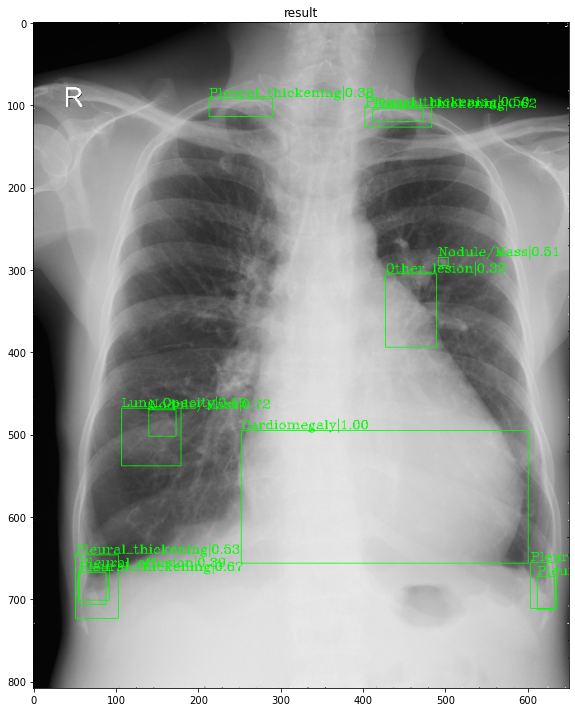

In [17]:
_id = random.randint(1,1098)
# Use the detector to do inference
img = f'../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_images/{val_ids[_id]}'
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

# Prediction Sample 

The output of the mmdet network is in the following form:

In [18]:
result

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[252.51387   , 495.7105    , 600.337     , 656.79156   ,
           0.99542844]], dtype=float32),
 array([[1.0566442e+02, 4.7153159e+02, 1.8335837e+02, 5.3872510e+02,
         1.2697273e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[1.0497773e+02, 4.6413708e+02, 1.8634514e+02, 5.4160980e+02,
         1.0600594e-01]], dtype=float32),
 array([[1.0702637e+02, 4.6824048e+02, 1.7916827e+02, 5.3826996e+02,
         5.6121719e-01],
        [1.3539481e+02, 4.6675623e+02, 1.8088124e+02, 5.1230164e+02,
         1.3962409e-01],
        [5.7970924e+01, 4.5652603e+02, 2.4662950e+02, 6.7463416e+02,
         1.3344003e-01],
        [6.8423897e+01, 4.6712936e+02, 1.9291615e+02, 6.0372888e+02,
         1.3046661e-01],
        [4.1163373e+02, 3.0605502e+02, 4.9883130e+02, 4.0756909e+02,
         5.9943002e-02]], dtype=float32),
 array([[1.4060455e+0

In [19]:
import os
os.makedirs("../vinbig_output")

# Train the model using the python command

In [20]:
# !python tools/train.py ./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py --cfg-options dataset_type='CocoDataset' classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.train.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.ann_file='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json' data.train.type='CocoDataset' data.val.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.val.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.val.ann_file='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_annotations.json' data.val.type='CocoDataset' data.test.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.test.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.test.ann_file='./test_ann.json' data.test.type='CocoDataset' model.roi_head.bbox_head.num_classes='14' evaluation.metric='bbox' work_dir='../vinbig_output' load_from='./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth' total_epochs='1'


# Predicting For All the Test Images

In [21]:
!python tools/test.py ./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py ../../input/vinbig-mmdet-fasterrcnn-base12-epoch/vinbig_output/epoch_10.pth --cfg-options dataset_type='CocoDataset' classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.train.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.train.ann_file='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/train_annotations.json' data.train.type='CocoDataset' data.val.img_prefix='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/' data.val.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.val.ann_file='../../input/vinbigdata-coco-dataset-with-wbf-3x-downscaled/vinbigdata-coco-dataset-with-wbf-3x-downscaled/val_annotations.json' data.val.type='CocoDataset' data.test.img_prefix='../../input/vinbigdata-1024-image-dataset/vinbigdata/test/' data.test.classes='("Aortic_enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung_Opacity", "Nodule/Mass", "Other_lesion", "Pleural_effusion", "Pleural_thickening", "Pneumothorax", "Pulmonary_fibrosis")' data.test.ann_file='./test_ann.json' data.test.type='CocoDataset' model.roi_head.bbox_head.num_classes='14' evaluation.metric='bbox' work_dir='../vinbig_output' load_from='./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth' total_epochs='1' --out results.pkl



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Use load_from_local loader
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3000/3000, 14.7 task/s, elapsed: 205s, ETA:     0s
writing results to results.pkl


# Plotting loss curve

In [22]:
# !python tools/analyze_logs.py plot_curve ../../input/vinbig-mmdet-fasterrcnn-base12-epoch/vinbig_output/None.log.json --keys lr --legend run1

In [23]:
os.listdir("./")

['tools',
 'pytest.ini',
 'demo',
 '.readthedocs.yml',
 'requirements',
 'setup.py',
 'mmdet',
 'setup.cfg',
 '.dev_scripts',
 'README.md',
 'docker',
 'mmdet.egg-info',
 '.git',
 'configs',
 '.github',
 'checkpoints',
 '.pre-commit-config.yaml',
 '.gitignore',
 'test_ann.json',
 'resources',
 'tests',
 'LICENSE',
 'results.pkl',
 'requirements.txt',
 'docs']

# Running Inference on Test Images

In [24]:
import pickle

with open('./results.pkl', 'rb') as f:
    data = pickle.load(f)

In [25]:

import json
with open('./test_ann.json', 'rb') as f:
    ann = json.load(f)

In [26]:
import pandas as pd
test_df = pd.read_csv('../../input/vinbigdata-original-image-dataset/vinbigdata/test.csv')

In [27]:
file_ids = [file_name.get('file_name').split('.png')[0] for file_name in ann.get('images')]

In [28]:
!pip install ensemble_boxes

# WBF on Test Predictions

In [29]:
from ensemble_boxes import *

In [30]:
ann_with_pred = zip(file_ids, data)
submission_vals = []
for _id, preds in ann_with_pred:
    boxes = []
    scores = []
    labels = []
    width = test_df[test_df.image_id==_id]['width'].iloc[0]
    height = test_df[test_df.image_id==_id]['height'].iloc[0]  
    for i, pred in enumerate(preds):
        if len(pred):
            for p in pred:
                box = p[:4]/1024
                boxes.append(box)
                score = p[4].astype(float)
                scores.append(score)
                labels.append(i)
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], iou_thr=0.4, skip_box_thr=0.4)
    boxes[:, 0] = boxes[:, 0]*height
    boxes[:, 2] = boxes[:, 2]*height
    boxes[:, 1] = boxes[:, 1]*width
    boxes[:, 3] = boxes[:, 3]*width
    
    scaled_boxes = boxes.astype(int)
    labels = labels.astype(int)
    _id_preds = []
    if len(scaled_boxes):
        for i in range(len(scaled_boxes)):
            _id_preds.append(str(labels[i]))
            _id_preds.append(str(scores[i].round(2)))
            _id_preds.append(str(scaled_boxes[i][0]))
            _id_preds.append(str(scaled_boxes[i][1]))
            _id_preds.append(str(scaled_boxes[i][2]))
            _id_preds.append(str(scaled_boxes[i][3]))
        pred_str = " ".join(_id_preds)
    else:
        pred_str = '14 1 0 0 1 1'
    submission_vals.append([_id, pred_str])



# Creating Submission file

In [31]:
df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df.head()

,image_id,PredictionString
0,b3f67ac077531f44dd06275af31edbd9,11 0.53 1980 310 2334 393
1,e94fde220360e4b769921e16059cc6af,0 0.98 1293 494 1532 704 3 0.8 1039 1130 1940 ...
2,d2993271d0a49d1d821db1174861629a,0 0.98 1343 663 1687 941 11 0.51 159 1754 245 ...
3,99732e844196448b90e50973d6ba5224,0 0.99 1617 682 1877 961 3 0.99 1240 1370 2318...
4,3c6f70f56258cad13d74e7f17da1c7c5,3 0.99 1165 1306 2368 1612 0 0.98 1543 710 190...


In [33]:
len(df)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3000

In [34]:
df.to_csv("submission.csv",index=False)

If you have reached till here, Thanks for your time!!